
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load EPEACS module
from epeacs.agents.epeacs import EPEACS, Configuration

from epeacs.agents.epeacs.utils.Plotting_wrapper import \
    parse_metrics_to_df, \
    plot_performance

from epeacs.metrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _state_of_population, \
    _enhanced_effect_error

# Load environments
import gym
import my_mazes

# Agent - EPEACS

## Common parameters

In [2]:
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "MazeE2-v0"

NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
BETA_ALP = 0.05
BETA_RL = 0.05
EPSILON = 0.8

DO_GA = False
ENABLE_PEP = True

SLIPPERY_PROB = 0.

NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00

NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05

NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

LENGTH_OF_BEHAVIORAL_SEQUENCES = 1

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ A ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ □ $ □ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of EPEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = EPEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 3min 19s, sys: 1.47 s, total: 3min 20s
Wall time: 3min 47s


### Performance

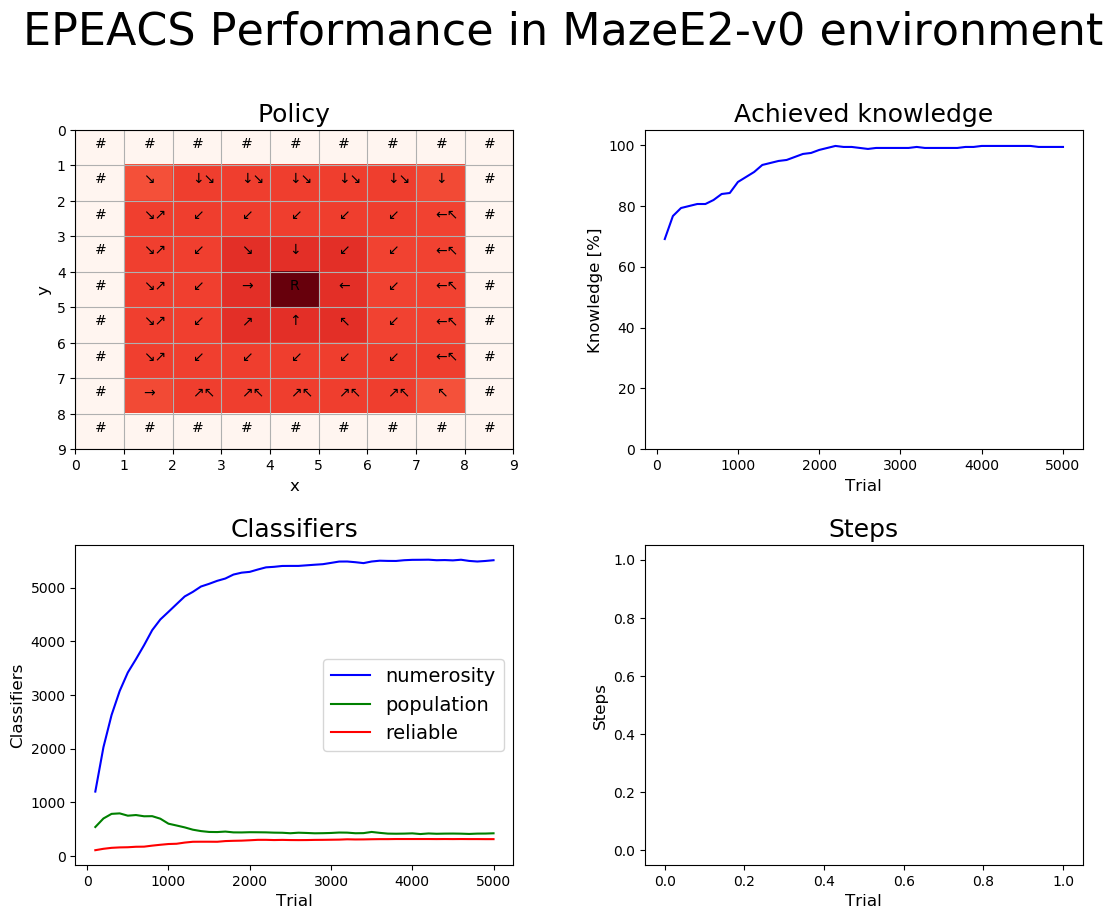

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
print(_maze_metrics(population_explore, maze))

first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)

print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.")

print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))

print(_state_of_population(metrics_explore, last_trial, METRICS_TRIAL_FREQUENCY_EXPLORE))

old_error, new_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities : old->", old_error, "% new->", new_error, "%")

{'knowledge': 99.3421052631579, 'population': 424, 'numerosity': 5512, 'reliable': 315}
Full knowledge was achieved at trials  -1 , was stable at  -1  and the last time it was achieved at  -1
There are  0  enhanced classifer(s) that match a non-aliased states.
Mean reliable population specifity is  0.523015873015873
{'trial': 4900, 'steps_in_trial': 6, 'reward': 1000, 'knowledge': 99.3421052631579, 'population': 419, 'numerosity': 5498, 'reliable': 315}
Accumulated Error on PEP Probabilities : old-> 0.3452482306446539 % new-> 0.3452482306446539 %


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore
    if cl.is_enhanced() or cl.behavioral_sequence]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

1100#001 4 [3] (0#11###0:#293, 00#9###0:#390, 00##9##0:#395, 00###9#0:#337, 00#####0:#291) (empty)               
q: 1.0   ra: 924.3  rb: 924.5  ir: 0.0    f: 924.3  
exp: 1627 tga: 127282 tbseq: 14421 talp: 127282 tav: 30.9   num: 17 ee: False


00011100 1 [7] (#9#000##:#225, 9##000##:#273, ###000#9:#239, ###000##:#390) (empty)               
q: 1.0   ra: 924.0  rb: 928.1  ir: 0.0    f: 924.0  
exp: 1076 tga: 127217 tbseq: 28886 talp: 127260 tav: 79.8   num: 1 ee: False


#0011100 1 [7] (#9#000##:#226, 9##000##:#272, ###000#9:#239, ###000##:#390) (empty)               
q: 1.0   ra: 931.9  rb: 921.5  ir: 0.0    f: 921.5  
exp: 1078 tga: 127217 tbseq: 28815 talp: 127260 tav: 79.8   num: 17 ee: False


00011100 7 [1] (###000#9:#117, 9##000##:#144, #9#000##:#132, ###000##:#253) (empty)               
q: 1.0   ra: 916.6  rb: 917.6  ir: 0.0    f: 916.6  
exp: 640 tga: 127212 tbseq: 4636  talp: 127212 tav: 2.33e+02 num: 20 ee: False


00000111 3 [1] (#9###000:#203, ##9##000:#220, #####000:#2

In [8]:
agent_explore.get_pai_states_memory()

[('0', '0', '0', '0', '0', '1', '1', '1'),
 ('0', '0', '0', '0', '0', '0', '0', '0'),
 ('1', '1', '0', '0', '0', '0', '0', '1'),
 ('0', '0', '0', '1', '1', '1', '0', '0'),
 ('0', '1', '1', '1', '0', '0', '0', '0')]

## Training of EPEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_no_rl = EPEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 1min 23s, sys: 326 ms, total: 1min 23s
Wall time: 1min 28s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl_start = EPEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 1min 18s, sys: 305 ms, total: 1min 18s
Wall time: 1min 22s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = EPEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 1min 14s, sys: 137 ms, total: 1min 15s
Wall time: 1min 15s


### Performance

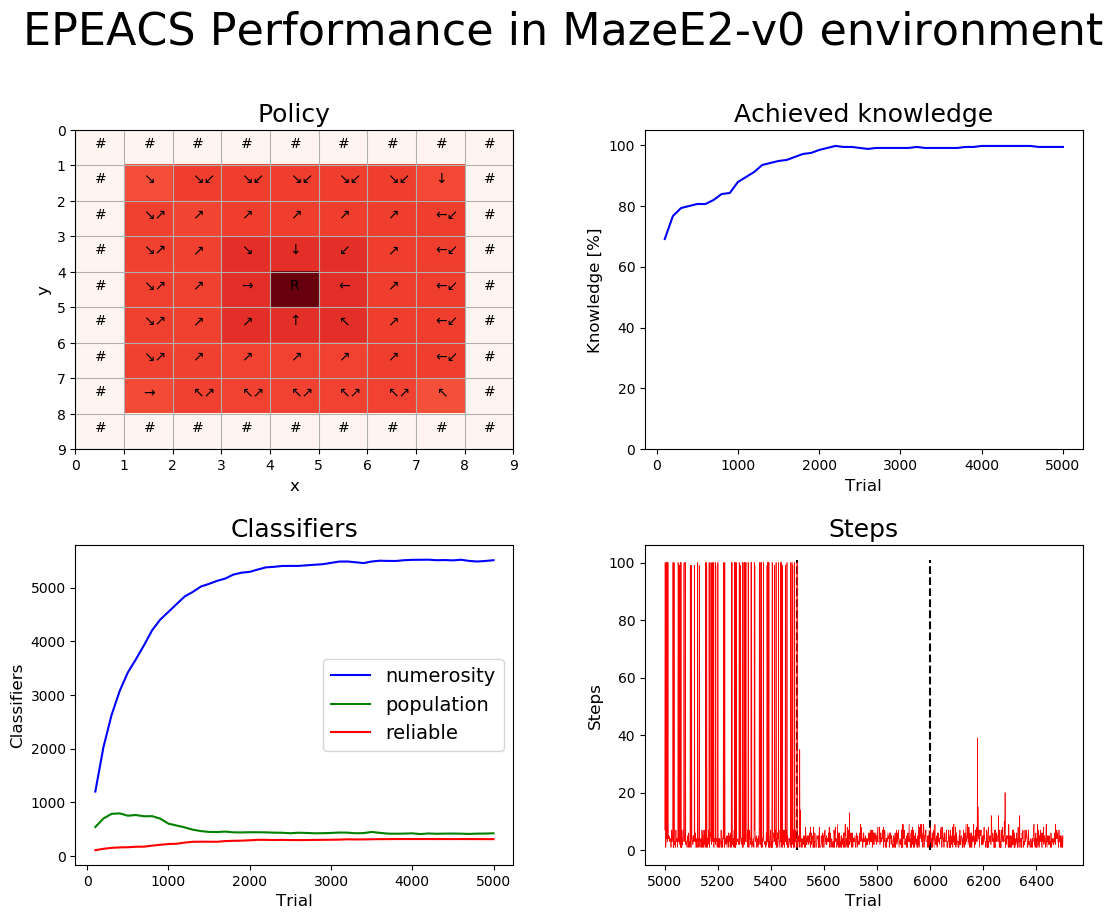

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  30.2  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  18.714  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  3.868  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  4.024  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 99.3421052631579, 'population': 424, 'numerosity': 5512, 'reliable': 315}
{'knowledge': 99.3421052631579, 'population': 424, 'numerosity': 5512, 'reliable': 315}
{'knowledge': 99.3421052631579, 'population': 424, 'numerosity': 5512, 'reliable': 315}
{'knowledge': 99.3421052631579, 'population': 424, 'numerosity': 5512, 'reliable': 315}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl 
    if cl.behavioral_sequence]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print(cl.pai_state)
    print("\n")
#from epeacs.agents.epeacs import ClassifiersList
#print(len(ClassifiersList(*list(dict.fromkeys(population_exploit_rl_to_display)))))

284


1100#001 3 [5] (00#####0:#258, 00###9#0:#143, 00#9###0:#173, 00##9##0:#162) (empty)               
q: 1.0   ra: 924.4  rb: 926.8  ir: 0.0    f: 924.4  
exp: 725 tga: 127117 tbseq: 15038 talp: 127117 tav: 2.49e+02 num: 17 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


011100#0 6 [5] (#00#11##:#115, #000#9##:#132, #000####:#140, #000##9#:#141, #000###9:#141) (empty)               
q: 1.0   ra: 941.5  rb: 923.3  ir: 0.0    f: 923.3  
exp: 652 tga: 127232 tbseq: 9561  talp: 127232 tav: 70.3   num: 16 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


1100#001 4 [3] (0#11###0:#293, 00#9###0:#390, 00##9##0:#395, 00###9#0:#337, 00#####0:#291) (empty)               
q: 1.0   ra: 910.3  rb: 924.8  ir: 0.0    f: 910.3  
exp: 1627 tga: 127282 tbseq: 14421 talp: 127282 tav: 30.9   num: 17 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


11000001 5 [5] (00###11#:#175, 00##9##0:#75, 00#9###0:#86, 00#####0:#89) (empty)               
q: 1.0   ra: 909.9  rb: 913.0  ir: 0.0    f: 909.